# Exploring XKCD strips

<p align="center">
  <img src="https://xkcd.com/s/0b7742.png" />
</p>

This notebook uses data from [xkcd](https://xkcd.com/) strips to explore and do some analysis. The strips transcripts were scraped from [https://www.explainxkcd.com](https://www.explainxkcd.com).

# Imports

We'll start with our basic imports:

In [1]:
import pickle
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import sqlite3 as sql
import re

In [2]:
import plotly.io as pio
pio.templates.default = "simple_white"

# Reading from database

The data was saved with our [scraper](scraper.py) in a data base named simply `xkcd.db`. Let's connect to the database and read all non-duplicate data:

In [3]:
# Connecting to our db
con = sql.connect("xkcd.db")
cur = con.cursor()

Let's see if we have any duplicates in our set (I had to manually restart the scraper, so duplicates are bound to be there...).

In [4]:
# Cheking for duplicates using ROW_NUMBER()
query = """
WITH CTE(
	[number], 
    [date], 
    [title],
	[transcript],	
    duplicatecount)
AS (SELECT [number], 
           [date], 
           [title],
		   [transcript], 
           ROW_NUMBER() OVER(
				PARTITION BY [number]
				ORDER BY number)
					AS DuplicateCount
    FROM xkcd_strips)
SELECT *
FROM CTE
WHERE
	duplicatecount > 1;
"""
df_duplicates = pd.read_sql(query, con)

In [5]:
df_duplicates

,number,date,title,transcript,duplicatecount
0,362,"December 26, 2007",Blade Runner,Friend: What DVD is this?\nCueball: Blade Runn...,2
1,714,"March 15, 2010",Porn For Women,"[Megan sits at a desk, typing on a computer wi...",2
2,808,"October 20, 2010",The Economic Argument,[A three-column table. The headings are actual...,2
3,919,"July 1, 2011",Tween Bromance,[All of Cueball's lines are overlaid over the ...,2
4,999,"January 4, 2012",Cougars,[Cueball is sitting at a computer; a child is ...,2
5,1100,"August 27, 2012",Vows,"[A bride in full wedding dress, that looks lik...",2
6,1466,"December 29, 2014",Phone Checking,[Cueball approaching Megan.]\nCueball: What's ...,2
7,1760,"November 16, 2016",TV Problems,"[Cueball is sitting by his TV, holding his pho...",2
8,2029,"August 6, 2018",Disaster Movie,[A fraction of an office with two desks is sho...,2


Yep, there they are. Let's only work with none duplicate ones. We can create a dataframe by including only rows with `duplicatecount` equal to one:

In [6]:
# Reading only non-duplicate data
query = """
WITH CTE(
	[number], 
    [date], 
    [title],
	[transcript],	
    duplicatecount)
AS (SELECT [number], 
           [date], 
           [title],
		   [transcript], 
           ROW_NUMBER() OVER(
				PARTITION BY [number]
				ORDER BY number)
					AS DuplicateCount
    FROM xkcd_strips)
SELECT
    	[number], 
        [date], 
        [title],
        [transcript]
FROM CTE
WHERE
	duplicatecount = 1;
"""
xkcd_df = pd.read_sql(query, con)

In [7]:
xkcd_df.head()

,number,date,title,transcript
0,1,"September 30, 2005",Barrel - Part 1,[A boy sits in a barrel which is floating in a...
1,2,"September 30, 2005",Petit Trees (sketch),[Two trees are growing on opposite sides of a ...
2,3,"September 30, 2005",Island (sketch),[A color sketch of an island.]
3,4,"September 30, 2005",Landscape (sketch),[A sketch of a landscape with sun on the horiz...
4,5,"October 25, 2005",Blown apart,[A black number 70 sees a red package. This sm...


In [8]:
len(xkcd_df)

2644

## Getting strip image URL

To get the strip image, we can use our previous dataset scraped directly from the XKCD site and merge it with this one.

In [9]:
# Getting data from our pickled object

data_list = pickle.load( open( "data_list.pickle", "rb" ) )
xkcd_og = pd.DataFrame(data_list)

In [10]:
xkcd_og.head()

,month,num,link,year,news,safe_title,transcript,alt,img,title,day,extra_parts
0,1,1,,2006,,Barrel - Part 1,[[A boy sits in a barrel which is floating in ...,Don't we all.,https://imgs.xkcd.com/comics/barrel_cropped_(1...,Barrel - Part 1,1,NaN
1,1,2,,2006,,Petit Trees (sketch),[[Two trees are growing on opposite sides of a...,"'Petit' being a reference to Le Petit Prince, ...",https://imgs.xkcd.com/comics/tree_cropped_(1).jpg,Petit Trees (sketch),1,NaN
2,1,3,,2006,,Island (sketch),"[[A sketch of an Island]]\n{{Alt:Hello, island}}","Hello, island",https://imgs.xkcd.com/comics/island_color.jpg,Island (sketch),1,NaN
3,1,4,,2006,,Landscape (sketch),[[A sketch of a landscape with sun on the hori...,There's a river flowing through the ocean,https://imgs.xkcd.com/comics/landscape_cropped...,Landscape (sketch),1,NaN
4,1,5,,2006,,Blown apart,[[A black number 70 sees a red package.]]\n70:...,Blown into prime factors,https://imgs.xkcd.com/comics/blownapart_color.jpg,Blown apart,1,NaN


In [11]:
# Rename the number column
xkcd_og = xkcd_og.rename(columns={"num": "number"})

In [12]:
# Merging dataframes

pd.merge(xkcd_df, xkcd_og, how="inner", on="number")[["number", "date", "title_x", "transcript_x", "img"]].head()

,number,date,title_x,transcript_x,img
0,1,"September 30, 2005",Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...
1,2,"September 30, 2005",Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg
2,3,"September 30, 2005",Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg
3,4,"September 30, 2005",Landscape (sketch),[A sketch of a landscape with sun on the horiz...,https://imgs.xkcd.com/comics/landscape_cropped...
4,5,"October 25, 2005",Blown apart,[A black number 70 sees a red package. This sm...,https://imgs.xkcd.com/comics/blownapart_color.jpg


In [13]:
xkcd_eda = pd.merge(xkcd_df, xkcd_og, how="inner", on="number")[["number", "date", "title_x", "transcript_x", "img"]]

In [14]:
xkcd_eda.head()

,number,date,title_x,transcript_x,img
0,1,"September 30, 2005",Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...
1,2,"September 30, 2005",Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg
2,3,"September 30, 2005",Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg
3,4,"September 30, 2005",Landscape (sketch),[A sketch of a landscape with sun on the horiz...,https://imgs.xkcd.com/comics/landscape_cropped...
4,5,"October 25, 2005",Blown apart,[A black number 70 sees a red package. This sm...,https://imgs.xkcd.com/comics/blownapart_color.jpg


In [15]:
len(xkcd_eda)

2641

We can rename the columns for a better read:

In [16]:
xkcd_eda = xkcd_eda.rename(columns={"title_x": "title", "transcript_x": "transcript"})

In [17]:
xkcd_eda.head()

,number,date,title,transcript,img
0,1,"September 30, 2005",Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...
1,2,"September 30, 2005",Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg
2,3,"September 30, 2005",Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg
3,4,"September 30, 2005",Landscape (sketch),[A sketch of a landscape with sun on the horiz...,https://imgs.xkcd.com/comics/landscape_cropped...
4,5,"October 25, 2005",Blown apart,[A black number 70 sees a red package. This sm...,https://imgs.xkcd.com/comics/blownapart_color.jpg


# Cleaning the transcripts



Before cleaning the text, we can get rid of contractions to avoid issues in the future. For that, we'll use the `contractions` module.

First, we can build a function to take raw text and expand contractions.

In [18]:
import contractions

In [19]:
def handle_contractions(s):
    """
    Helper function to get rid of english words contractions.

    Args:
        s (string): a string of text (in english)

    Returns:
        string: the same string without word contractions.
    """
    return contractions.fix(s)

In [20]:
xkcd_eda['clean_transcript'] = xkcd_eda['transcript'].apply(handle_contractions)

Let's remove all non alphanumeric characters so we can deal with text in transcripts:

In [21]:
xkcd_eda['clean_transcript'] = xkcd_eda['clean_transcript'].apply(lambda s: re.sub(r'[^\w]', ' ', s))

In [22]:
xkcd_eda.head()

,number,date,title,transcript,img,clean_transcript
0,1,"September 30, 2005",Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...,A boy sits in a barrel which is floating in a...
1,2,"September 30, 2005",Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg,Two trees are growing on opposite sides of a ...
2,3,"September 30, 2005",Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg,A color sketch of an island
3,4,"September 30, 2005",Landscape (sketch),[A sketch of a landscape with sun on the horiz...,https://imgs.xkcd.com/comics/landscape_cropped...,A sketch of a landscape with sun on the horiz...
4,5,"October 25, 2005",Blown apart,[A black number 70 sees a red package. This sm...,https://imgs.xkcd.com/comics/blownapart_color.jpg,A black number 70 sees a red package This sm...


# Seeing the comic strip

In [23]:
from PIL import Image
import requests

To set up a "show strip" function, we'll use the number of the strip as input as it is a unique indentifier. Let's first run a quick sanity check to see if it is indeed unique:

In [24]:
def show_strip(num):
    """
    Function to plot an XKCD strip given its number.

    Args:
        num (int): XKCD strip number.
    """
    # Get url for strip
    url = xkcd_eda.query(f"number == {num}")["img"].iloc(0)[0]

    im = Image.open(requests.get(url, stream=True).raw)

    plt.figure(figsize = (12,12))
    plt.imshow(im, cmap='gray', aspect='equal')
    plt.axis('off');

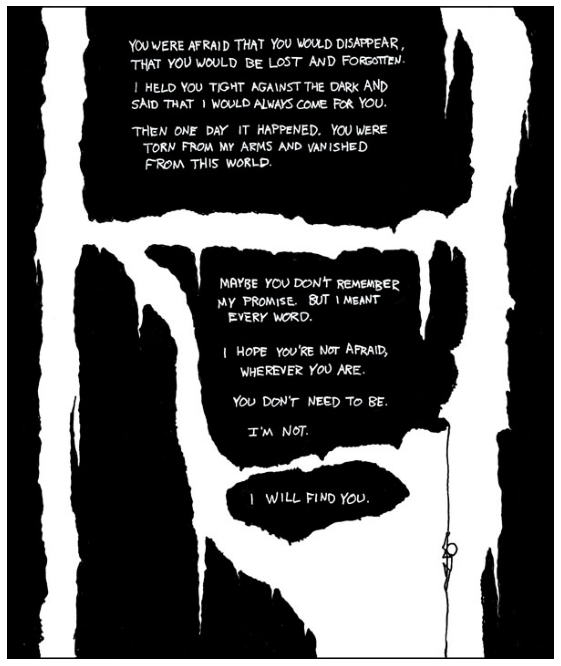

In [25]:
show_strip(104)

Cool, it works!

# Analyzing transcripts

## Processing using spacy

[Here](https://realpython.com/natural-language-processing-spacy-python/#what-are-nlp-and-spacy) is a great article!

We'll use the `clean_transcript` to do all processing.

### Converting everything to lower case

In [26]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [27]:
xkcd_eda['clean_transcript'] = xkcd_eda['clean_transcript'].str.lower()

Let's move the new column to the front for a better visual:

In [28]:
xkcd_eda.insert(0, 'clean_transcript', xkcd_eda.pop('clean_transcript'))

In [29]:
xkcd_eda.head(3)

,clean_transcript,number,date,title,transcript,img
0,a boy sits in a barrel which is floating in a...,1,"September 30, 2005",Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...
1,two trees are growing on opposite sides of a ...,2,"September 30, 2005",Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg
2,a color sketch of an island,3,"September 30, 2005",Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg


### Removing stopwords

First we'll create a function that takes a string (text) and returns a string with no stopwords (using spacy).

In [30]:
def text_no_stop_words(s):
    """
    Function to remove stop words from text. This function uses stop words from 'spacy'.

    Args:
        s (strin): A string of text (in english)

    Returns:
        string: The same string of text with stop words removed.
    """
    text_content = s

    doc = nlp(text_content)
    # The .orth_ attribute returns a string representation of the token
    no_stopword_doc = [token.orth_ for token in doc if not token.is_stop]
    
    return " ".join(no_stopword_doc)

Now we can apply the function to the column:

In [31]:
xkcd_eda['clean_transcript'] = xkcd_eda['clean_transcript'].apply(text_no_stop_words)

### Removing unwanted white space

There are a lot of white spaces in our text! Let's remove them:

In [32]:
xkcd_eda.iloc[0]['clean_transcript']

'  boy sits barrel floating ocean    boy   wonder float   smaller frame zoom boy barrel seen afar   barrel drifts distance   seen  '

In [33]:
xkcd_eda['clean_transcript'] = xkcd_eda['clean_transcript'].apply(lambda s: " ".join(s.split()))

In [34]:
xkcd_eda.iloc[0]['clean_transcript']

'boy sits barrel floating ocean boy wonder float smaller frame zoom boy barrel seen afar barrel drifts distance seen'

Much better!

### Lemmatization

> Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced form belongs to the language. This reduced form or root word is called a lemma.

> For example, organizes, organized and organizing are all forms of organize. Here, organize is the lemma. The inflection of a word allows you to express different grammatical categories like tense (organized vs organize), number (trains vs train), and so on. Lemmatization is necessary because it helps you reduce the inflected forms of a word so that they can be analyzed as a single item. It can also help you normalize the text.

> spaCy has the attribute lemma_ on the Token class. This attribute has the lemmatized form of a token.

As before, we'll create a function that takes strings and returns the lemmatized version of the text.

In [35]:
def text_lemmatized(s):
    """
    Function to return a string of text after lemmatization. Lemmatization is done using 'spacy'.

    Args:
        s (string): A string of text in english.

    Returns:
        string: The same string of text after lemmatization.
    """
    text_content = s

    doc = nlp(text_content)
    # The .orth_ attribute returns a string representation of the token
    lemmatized_doc = [token.lemma_ for token in doc]
    
    return " ".join(lemmatized_doc)

In [36]:
text_lemmatized(xkcd_eda['clean_transcript'][0])

'boy sit barrel float ocean boy wonder float small frame zoom boy barrel see afar barrel drift distance see'

Now we apply to the whole column:

In [37]:
xkcd_eda['clean_transcript'] = xkcd_eda['clean_transcript'].apply(text_lemmatized)

In [38]:
xkcd_eda.head()

,clean_transcript,number,date,title,transcript,img
0,boy sit barrel float ocean boy wonder float sm...,1,"September 30, 2005",Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...
1,tree grow opposite side sphere,2,"September 30, 2005",Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg
2,color sketch island,3,"September 30, 2005",Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg
3,sketch landscape sun horizon text checker pape...,4,"September 30, 2005",Landscape (sketch),[A sketch of a landscape with sun on the horiz...,https://imgs.xkcd.com/comics/landscape_cropped...
4,black number 70 see red package small panel pa...,5,"October 25, 2005",Blown apart,[A black number 70 sees a red package. This sm...,https://imgs.xkcd.com/comics/blownapart_color.jpg


### Adding word count

For this new feature we'll use the full `transcript` (not cleaned). This way, we can measure the true amount of words (or tokens, I should say) each transcript has. As before, let's build a function that takes a raw string and returns the number of tokens in it.

In [39]:
def word_count(s):
    """
    Function to count number of wrods in a string of text.

    Args:
        s (string): A string of text.

    Returns:
        int: The number of words in the input text.
    """
    text_content = s

    doc = nlp(text_content)
    
    return len(doc)

In [40]:
word_count(xkcd_eda['transcript'][0])

55

In [41]:
xkcd_eda['word_count'] = xkcd_eda['transcript'].apply(word_count)

Let's just quickly save our dataframe as a csv before we go on.

In [42]:
xkcd_eda.to_csv("data/xkcd_eda.csv", index=False)

Let's see the distribution of word counts:

In [43]:
fig = px.histogram(xkcd_eda,
                   x='word_count',
                   title = 'Word count distribution - xkcd transcripts')
fig.show()

Let's add a little bit more to this chart. I want to see the mean value as  vertical line there.

In [44]:
fig = px.histogram(xkcd_eda,
                    x='word_count',
                    title = 'Word count distribution - xkcd transcripts')
fig.add_vline(x=xkcd_eda['word_count'].mean(), line_width=3,
                    line_dash="dash", line_color="red", annotation_text= "Mean")
# fig.add_vline(x=xkcd_eda['word_count'].median(), line_width=3,
#                     line_dash="dash", line_color="green", annotation_text= "Median")



fig.show()

In [45]:
xkcd_eda['word_count'].describe()

count    2641.000000
mean      195.588792
std       214.526068
min         0.000000
25%        86.000000
50%       141.000000
75%       228.000000
max      3915.000000
Name: word_count, dtype: float64

Which one is the strip with almost 4000 words of transcript?

In [46]:
xkcd_eda.query("word_count > 3000")

,clean_transcript,number,date,title,transcript,img,word_count
1035,note courageous reader transcript reorder orde...,1037,"April 1, 2012",Umwelt,[Note to courageous readers- The transcript ha...,https://imgs.xkcd.com/comics/reviews.png,3720
1729,large heading follow sub caption line statemen...,1732,"September 12, 2016",Earth Temperature Timeline,"[A large heading, followed by a sub-caption. B...",https://imgs.xkcd.com/comics/earth_temperature...,3915


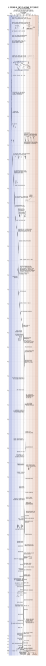

In [47]:
show_strip(1732)

Yep, that's a big one! Every now and then, Randall gets carried away and give us something like this.... It's awesome!

In [48]:
xkcd_eda.iloc[1729]["transcript"][:1000]

'[A large heading, followed by a sub-caption. Below that two lines with a statement in between:]\nA timeline of Earth’s average temperature\nsince the last ice age glaciation\nWhen people say “The climate has changed before,” these are the kinds of changes they’re talking about.[A very long chart below the headings above is headed with a label for the scale of the X-axis above the chart. Below that a sub-caption. To the left an arrow down to the top of the chart pointing to the dotted curves starting point (at -4.3°C below the 1961-1990 average) with a label above the arrow. And arrow pointing left to the left of the center and another pointing right to the right of the center has labels. Below these is the temperature scale of the X-axis, with 9 ticks between the borders each with a label ranging from -4 to +4°C compared to the 1961-1990 average, but with another step in each direction not labeled towards to axis so the chart covers -5 to +5°C compared to the 1961-1990 average.]\nTemp

The next one actually has a mistake in the image file URL. The mistake is there in the json file. If we look it up, it will show the wrong strip:

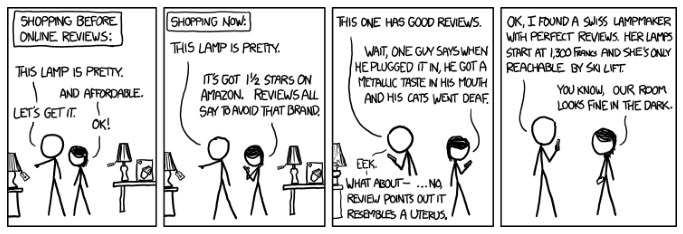

In [49]:
show_strip(1037)

This strip actually uses Javascript as it is dynamic. The static image for those browsers that do not support javascript is [here](https://www.explainxkcd.com/wiki/images/f/ff/umwelt_the_void.jpg).

We can manually change it in the dataframe:

In [50]:
xkcd_eda.at[1035, 'img'] = "https://www.explainxkcd.com/wiki/images/f/ff/umwelt_the_void.jpg"

Let's try seing the static image now:

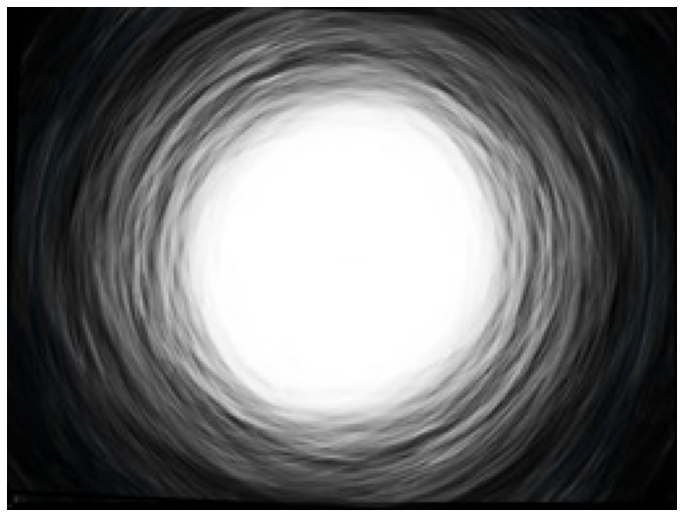

In [51]:
show_strip(1037)

Perfect!

## Word frequency

We can use our clean transcripts to get the frequency of words. We can do this using `pandas` and basic python methods. The process can be broken up into parts:

* Join all (clean) transcripts in a single string using the `.join()` method - `' '.join(xkcd_eda['clean_transcripts'])`
* Using the `split()` method, break down the joined big string into a list of single tokens (words).
* Put this list into a pandas `Series` object.
* Use the `value_counts()` methods for pandas `Series` to get the count of each different element in the `Series`.

In [52]:
word_freq = pd.Series(' '.join(xkcd_eda['clean_transcript']).split()).value_counts()

In [53]:
word_freq[:20]

cueball     7497
megan       3387
panel       2801
right       1709
line        1587
s           1548
hat         1477
leave       1425
ponytail    1364
black       1361
look        1195
show        1140
label       1131
white       1111
hold        1100
hand        1075
text        1027
like        1025
small        925
guy          922
dtype: int64

We can now plot the most frequent words in the trsnacripts:

In [54]:
fig = px.bar(word_freq[:20])
fig.update_layout(showlegend=False,
                  title="Most frequent words",
                  xaxis_title="Word",
                  yaxis_title="Frequency")
fig.show()

Well, a bit of context may help out here:
* *Cueball* is the unofficial name given to the generic stick figure in XKCD comics. Check it out [here](https://www.explainxkcd.com/wiki/index.php/Cueball)
* *Megan* is, basically, the female generic stick figure in the comics. Check it out [here](https://www.explainxkcd.com/wiki/index.php/Megan).
* *Black Hat* and *White Hat* are other recurrent characters in the strips. Check them out [here](https://www.explainxkcd.com/wiki/index.php/Black_Hat) and [here](https://www.explainxkcd.com/wiki/index.php/White_Hat).

It is very common for the XKCD strips to have charts and graphs, so a lot of descriptive words, like `panel`, `line` and `label` do appear as most frequent ones.

# Doing polarity and subjectivity using [spacytextblob](https://spacy.io/universe/project/spacy-textblob).

In [55]:
from spacytextblob.spacytextblob import SpacyTextBlob

In [56]:
nlp.add_pipe('spacytextblob')

In [57]:
# !python3 -m textblob.download_corpora

In [58]:
# text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
# doc = nlp(text)
# print(doc._.blob.polarity                            )
# print(doc._.blob.subjectivity                        )
# print(doc._.blob.sentiment_assessments.assessments   )
# print(doc._.blob.ngrams()                            )

## Polarity

As before, we want a function that takes text and gives us a polarity score.

In [59]:
def get_polarity(s):
    """
    Function to return the polarity of a string of text. Polarity is given using 'spacytextblob'

    Args:
        s (string): A string of text in english.

    Returns:
        float: The polarity of the input text. Range [-1.0, 1.0]
    """
    text_content = s

    doc = nlp(text_content)
    
    return doc._.blob.polarity

In [60]:
xkcd_eda['polarity'] = xkcd_eda['transcript'].apply(get_polarity)

Let's see the distribtuion of polarity of strips:

In [61]:
fig = px.histogram(xkcd_eda,
                   x='polarity',
                   title = 'Polarity distribution - xkcd transcripts')

fig.add_vline(x=xkcd_eda['polarity'].mean(), line_width=3,
                    line_dash="dash", line_color="red", annotation_text= f"Mean - {xkcd_eda['polarity'].mean():.3f}")
fig.show()

The polarity score is a float within the range [-1.0, 1.0] that gives a measure on the sentiment of the text. A polarity of 1.0 means a super positive text, and -1.0 a super negative one. We can see that the average of transcripts is close to zero, having slightly more negative cases.

We can try to see of there is any relation between polarity and word counts:

In [62]:
fig = px.scatter(xkcd_eda, x = 'word_count', y = 'polarity',
                 title = 'Polarity vs. Word count')

fig.show()

It seems high word count comes with neutral text.

## Subjectivity

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [63]:
def get_subjectivity(s):
    """
    FUnction to return the subjectivity of a string of text. Subjectivity is calculated using 'spacytextblob'.

    Args:
        s (string): A string of text.

    Returns:
        float: The subjectivity of the input text. Range [0.0, 1.0].
    """
    text_content = s

    doc = nlp(text_content)
    
    return doc._.blob.subjectivity

In [64]:
xkcd_eda['subjectivity'] = xkcd_eda['transcript'].apply(get_subjectivity)

Distribtuion:

In [65]:
fig = px.histogram(xkcd_eda,
                   x='subjectivity',
                   title = 'Subjectivity distribution - xkcd transcripts')

fig.add_vline(x=xkcd_eda['subjectivity'].mean(), line_width=3,
                    line_dash="dash", line_color="red", annotation_text= f"Mean - {xkcd_eda['subjectivity'].mean():.3f}")
fig.show()

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. Again, the distribution is centered close to 0.5 with a slightly tendency torwards more objective text.

In [66]:
fig = px.scatter(xkcd_eda, x = 'word_count', y = 'subjectivity',
                 title = 'Subjectivity vs. Word count')

fig.show()

Again, we notice that neutral text tends to have larger word counts.

In [67]:
# Saving the current df
xkcd_eda.to_csv("data/xkcd_eda.csv")

# Finding Bi-grams

In [68]:
import nltk
from nltk import word_tokenize

In [69]:
def bigram_plot(df, top=20):
    """
    Plot the top most frequent bigrams in df['clean_transcript']

    Args:
        df (pandas dataframe): Pandas dataframe containing a column named 'clean_transcript'.
        top (int, optional): Number of most frequent bigrams to show. Defaults to 20.
    """
    finder = nltk.collocations.BigramCollocationFinder.from_words(sum(df['clean_transcript'].map(word_tokenize), []))
    common = finder.ngram_fd.most_common(top)
    
    bigram_list = [(' '.join(el[0]), el[1]) for el in common]
    
    freq_df = pd.DataFrame(bigram_list, columns = ["Bigram","Frequency"])
    freq_df = freq_df.sort_values(by='Frequency', ascending=False)
    fig = px.bar(freq_df[:20], x = 'Bigram', y = 'Frequency',
             color=px.colors.qualitative.Light24[:20])
    fig.update_layout(
        showlegend=False,
        title=f"Top {top} more frequent bigrams",
        xaxis_title="Bigram",
        yaxis_title="Frequency"
    )
    fig.show()

In [70]:
bigram_plot(xkcd_eda)

The first two bi-grams are surely expected! A couple of funny ones turned up, like *cueball sit*, *hold hand*  and *arrow point*.

# Date

Since we have all these new features, lets see their evolution in time:

In [71]:
xkcd_eda['date'] = pd.to_datetime(xkcd_eda['date'])

In [72]:
xkcd_eda.head()

,clean_transcript,number,date,title,transcript,img,word_count,polarity,subjectivity
0,boy sit barrel float ocean boy wonder float sm...,1,2005-09-30,Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...,55,0.000000,0.500000
1,tree grow opposite side sphere,2,2005-09-30,Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg,13,0.000000,0.000000
2,color sketch island,3,2005-09-30,Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg,9,0.000000,0.000000
3,sketch landscape sun horizon text checker pape...,4,2005-09-30,Landscape (sketch),[A sketch of a landscape with sun on the horiz...,https://imgs.xkcd.com/comics/landscape_cropped...,33,0.500000,0.750000
4,black number 70 see red package small panel pa...,5,2005-10-25,Blown apart,[A black number 70 sees a red package. This sm...,https://imgs.xkcd.com/comics/blownapart_color.jpg,107,0.011111,0.282639


In [73]:
fig = px.line(xkcd_eda, x = 'date', y = 'polarity')
fig.show()

In [74]:
fig = px.line(xkcd_eda, x = 'date', y = 'subjectivity')
fig.show()

In [75]:
fig = px.line(xkcd_eda, x = 'date', y = 'word_count')
fig.show()

# Describing a single strip

Lets make the `show_strip` function a bit more usefull to let (possible) users explore the strips a little.

In [76]:
xkcd_eda.head()

,clean_transcript,number,date,title,transcript,img,word_count,polarity,subjectivity
0,boy sit barrel float ocean boy wonder float sm...,1,2005-09-30,Barrel - Part 1,[A boy sits in a barrel which is floating in a...,https://imgs.xkcd.com/comics/barrel_cropped_(1...,55,0.000000,0.500000
1,tree grow opposite side sphere,2,2005-09-30,Petit Trees (sketch),[Two trees are growing on opposite sides of a ...,https://imgs.xkcd.com/comics/tree_cropped_(1).jpg,13,0.000000,0.000000
2,color sketch island,3,2005-09-30,Island (sketch),[A color sketch of an island.],https://imgs.xkcd.com/comics/island_color.jpg,9,0.000000,0.000000
3,sketch landscape sun horizon text checker pape...,4,2005-09-30,Landscape (sketch),[A sketch of a landscape with sun on the horiz...,https://imgs.xkcd.com/comics/landscape_cropped...,33,0.500000,0.750000
4,black number 70 see red package small panel pa...,5,2005-10-25,Blown apart,[A black number 70 sees a red package. This sm...,https://imgs.xkcd.com/comics/blownapart_color.jpg,107,0.011111,0.282639


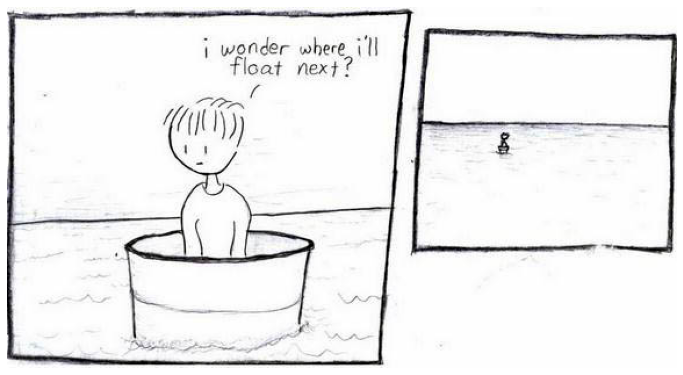

In [77]:
show_strip(1)

In [78]:
import numpy as np

In [79]:
def show_strip(num):
    """
    Show the strip given its number alongside a graph of the strip transcript's polarity and subjectivity.
    Args:

        num (int): xkcd strip number.
    """
    # Get url for strip
    url = xkcd_eda.query(f"number == {num}")["img"].iloc(0)[0]

    im = Image.open(requests.get(url, stream=True).raw)

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [3, 1]})
    title = xkcd_eda.query(f"number == {num}")["title"].iloc(0)[0]
    fig.suptitle(title, fontsize = 20, horizontalalignment = 'center')
    fig.tight_layout()

    # The strip
    plt.sca(ax = axes[0])
    plt.imshow(im, cmap='gray', aspect='equal')
    plt.axis('off')
    date = xkcd_eda.query(f"number == {num}")["date"].iloc(0)[0]
    axes[0].set_title("Published on " + date.strftime("%Y-%m-%d"), fontsize = 15)

    # Features plot
    plt.sca(ax = axes[1])
    X = ['Polarity', 'Subjectivity']
    X_axis = np.arange(len(X))
    Y_axis = [xkcd_eda.query(f"number == {num}")["polarity"].iloc(0)[0], xkcd_eda.query(f"number == {num}")["subjectivity"].iloc(0)[0]]
    y_color = [('green' if feat > 0 else 'red') for feat in Y_axis]
    plt.bar(X_axis, Y_axis, color = y_color)
    w_count = xkcd_eda.query(f"number == {num}")["word_count"].iloc(0)[0]
    axes[1].set_title("Transcript features - Word count: " + str(w_count), fontsize = 15)
    plt.xticks(X_axis, X)
    plt.axhline(y=0, color = 'k');

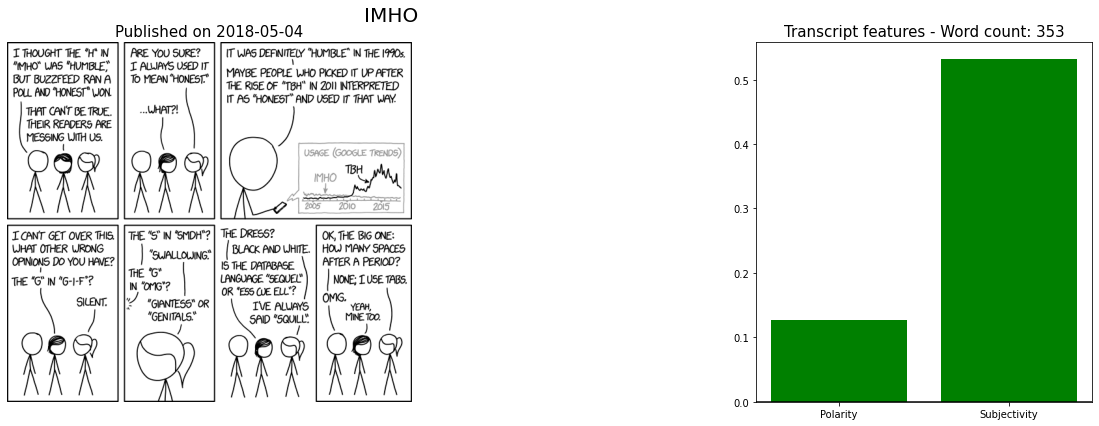

In [81]:
show_strip(1989)

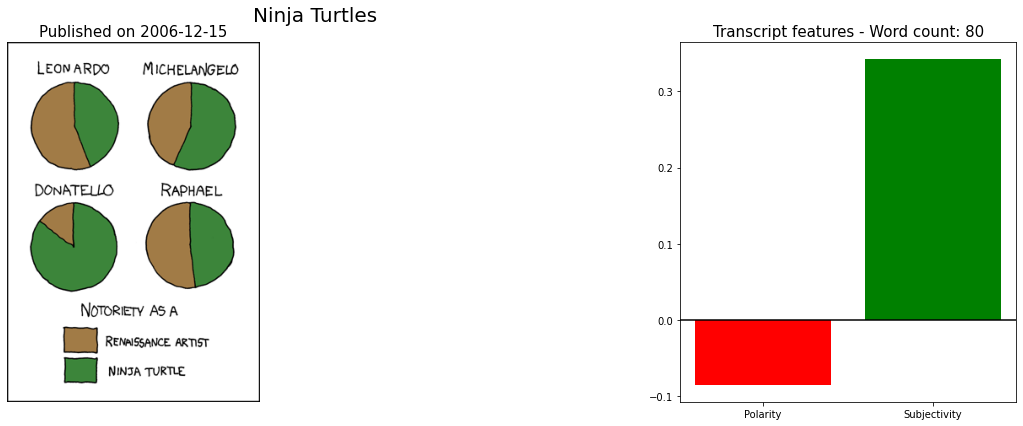

In [82]:
show_strip(197)

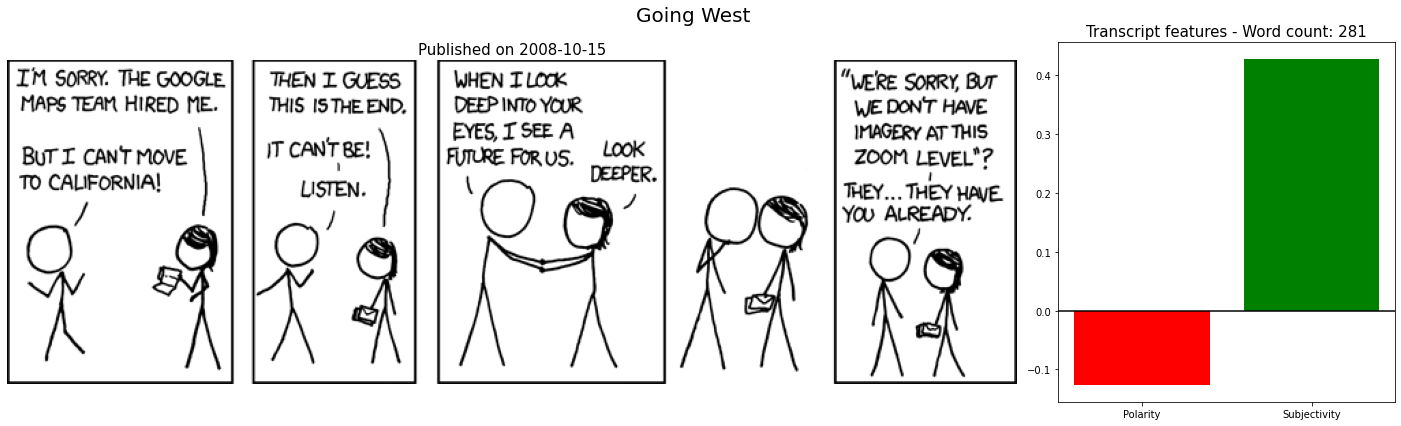

In [84]:
show_strip(489)